<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_ofdm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulate and demodulate with OFDM

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

## OFDM basics

Orthogonal Frequency Division Multiplexing (OFDM) is a modulation technique widely used in modern communication systems to transmit data over wireless or wired channels. It is particularly suitable for high-speed data transmission in environments with frequency-selective fading and interference.

OFDM works by dividing the available frequency spectrum into multiple subcarriers, each carrying a lower-rate data stream. These subcarriers are orthogonal to each other, meaning they are carefully spaced and designed such that their frequency spectra do not overlap and interfere with one another. This orthogonality ensures that each subcarrier can be independently modulated and demodulated without causing interference. The key idea behind OFDM is to convert a high-speed data stream into multiple parallel low-speed data streams, which are then modulated onto the individual subcarriers. By using multiple subcarriers, OFDM achieves a higher spectral efficiency compared to traditional single-carrier modulation schemes. This is because the subcarriers can be closely spaced, allowing efficient utilization of the available frequency spectrum.

In OFDM, the data stream is divided into blocks, and each block is converted into a set of complex-valued symbols corresponding to the amplitudes and phases of the subcarriers. These symbols are then transformed into the time domain using an inverse Fourier transform, resulting in a time-domain waveform. This waveform is then transmitted over the channel. At the receiver side, the received waveform is passed through a Fourier transform, known as the Fast Fourier Transform (FFT). This transforms the signal back into the frequency domain, allowing demodulation of the individual subcarriers. The demodulated subcarriers are then combined to reconstruct the original data stream.

OFDM provides several advantages in practical communication systems. One key advantage is its robustness against frequency-selective fading. Since the subcarriers are spaced apart and independently modulated, the effect of fading on one subcarrier is localized and does not significantly affect the other subcarriers. This makes OFDM particularly suitable for wireless channels with multipath propagation. Furthermore, OFDM is highly resistant to narrowband interference. Any interference affecting a specific subcarrier will only cause a slight degradation in the corresponding data stream, while the other subcarriers remain unaffected. This allows OFDM to maintain high data rates even in the presence of interference. OFDM has been adopted in various communication standards, such as Wi-Fi (IEEE 802.11), 4G LTE, and digital broadcasting systems like DVB-T and DAB. It forms the basis for the physical layer transmission in these systems, enabling efficient and reliable data communication.

In summary, OFDM is a modulation technique that divides the available frequency spectrum into orthogonal subcarriers. By transmitting data simultaneously on these subcarriers, OFDM achieves high spectral efficiency, robustness against fading, and resistance to narrowband interference. These characteristics make OFDM a crucial technology in modern communication systems, enabling high-speed and reliable data transmission.


### OFDM modulation

The input data stream is divided into blocks of size $N$, where $N$ is the number of subcarriers in the OFDM system.

1. **Symbol Mapping**: Each block of input data is mapped to a set of complex-valued symbols, one for each subcarrier. Let the  the complex-valued symbols for each subcarrier be denoted as $\boldsymbol{s} = [s_0, s_1, ..., s_{N-1}]$.

2. **Inverse Fourier Transform (IFFT)**: Perform an inverse Fourier transform (IFFT) on the complex-valued symbols to obtain the time-domain OFDM symbol $\boldsymbol{x} = [x_0, x_1, ..., x_{N-1}]$. This is done using the Fast Fourier Transform (FFT) algorithm. The IFFT operation can be expressed as:

$$
x_n = \frac{1}{\sqrt{N}} \sum_{k=0}^{N-1} s_k e^{j \frac{2\pi kn}{N}}
$$

3. **Parallel to Serial Conversion**: The time-domain OFDM symbol $\boldsymbol{x}$ is converted from parallel to serial format to create the OFDM waveform for transmission.

### OFDM demodulation

At the receiver side, the received OFDM waveform is processed to recover the original data.

1. **Serial to Parallel Conversion**: The received serial OFDM waveform is converted back to parallel format, creating the time-domain OFDM symbol $\boldsymbol{x}$.

2. **Fourier Transform (FFT)**: Perform a Fourier transform (FFT) on the time-domain OFDM symbol to obtain the frequency-domain representation of the received signal. This can be expressed as:

$$
y_k = \frac{1}{\sqrt{N}}\sum_{n=0}^{N-1} x_n e^{-j\frac{2\pi kn}{N}}
$$

3. **Symbol Detection**: Each subcarrier in the frequency domain is demodulated independently. The complex-valued symbols $\boldsymbol{y} = [y_0, y_1, ..., y_{N-1}]$ represent the received symbols for each subcarrier.

4. **Symbol Demapping**: The received symbols are demapped to obtain the corresponding data block.

5. **Error Detection and Correction**: The demodulated data block is processed to detect and correct any errors that occurred during transmission.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from optic.comm.ofdm import modulateOFDM, demodulateOFDM, calcSymbolRate
from optic.comm.modulation import modulateGray
from optic.dsp.core import pnorm, decimate, upsample, pulseShape, firFilter, lowPassFIR
from optic.comm.metrics import fastBERcalc, theoryBER
from optic.models.channels import awgn
from tqdm.notebook import tqdm
from optic.utils import parameters
from optic.plot import pconst, plotPSD

In [3]:
%load_ext autoreload
%autoreload 2

## Test modulation and demodulation of OFDM signals

OFDM signal parameters
Nfft: 256
G: 4
hermitSymmetry: False
SpS: 2
pilotCarriers: [  0 255]
Bit rate Rb = 128.00 Gb/s
Symbol rate Rs = 21.84 GBd
Sampling frequency Fs = 43.67 GSa/s


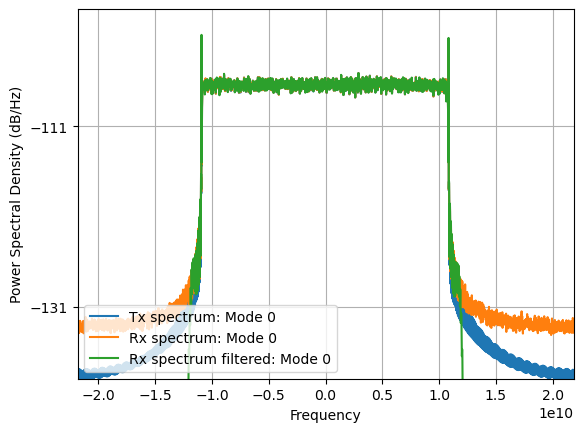

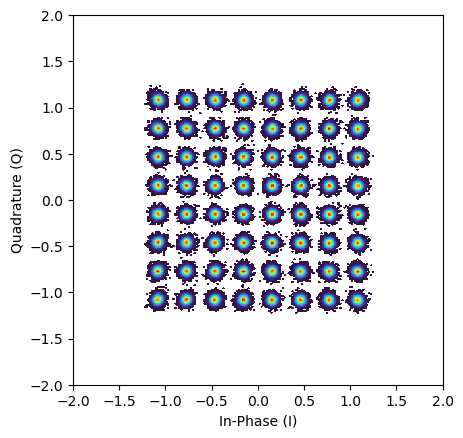

BER = 1.55e-05
BER (theory) = 2.63e-08


In [4]:
# Modulation parameters
M = 64          # modulation order
modType = 'qam' # type of modulation
Rb = 128e9      # Desired bit rate
SpS = 2         # samples per symbol

# OFDM signal parameters
paramOFDM = parameters()
paramOFDM.Nfft = 256            # FFT size
paramOFDM.G    = 4              # CP size
paramOFDM.hermitSymmetry = False
paramOFDM.SpS = SpS
paramOFDM.pilotCarriers = np.array([0, 255], dtype=np.int64) #np.arange(0,paramOFDM.Nfft,paramOFDM.Nfft//4)   # Pilot subcarriers
Np = len(paramOFDM.pilotCarriers)

Rs = calcSymbolRate(M, Rb, paramOFDM.Nfft, Np, paramOFDM.G, paramOFDM.hermitSymmetry)
Fs = Rs*SpS
print('OFDM signal parameters')
paramOFDM.view()
print(f'Bit rate Rb = {Rb/1e9:.2f} Gb/s')
print(f'Symbol rate Rs = {Rs/1e9:.2f} GBd')
print(f'Sampling frequency Fs = {Fs/1e9:.2f} GSa/s')

# Channel parameters
EbN0dB = 20

# Generate random bits
if paramOFDM.hermitSymmetry:
    bits = np.random.randint(2, size = int(np.log2(M)*(paramOFDM.Nfft//2 - 1 - Np))*2**10)
else:
    bits = np.random.randint(2, size = int(np.log2(M)*(paramOFDM.Nfft - Np))*2**10)

# Map bits to constellation symbols
symbTx = modulateGray(bits, M, modType)
symbTx = pnorm(symbTx)

# Pilot symbol choice
pilotSymb = 0.52*(max(symbTx.real) + 1j*max(symbTx.imag))
paramOFDM.pilot = pilotSymb

# OFDM symbols modulation
sigTx = modulateOFDM(symbTx, paramOFDM)

# AWGN channel
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
sigRx = awgn(sigTx, snrdB, Fs=Fs, B=1.1*Rs)

fig, ax = plotPSD(sigTx, Fs, label='Tx spectrum')
plotPSD(sigRx, Fs, fig=fig, label='Rx spectrum')

# low-pass filter
h = lowPassFIR(0.55*Rs, Fs, 128, typeF="rect")
if SpS > 1:
    sigRx = firFilter(h, sigRx) 

plotPSD(sigRx, Fs, fig=fig, label='Rx spectrum filtered')
plt.ylim(-139, -98)

# Decimation to 1 sample/symbol
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1

symbRx_OFDM = decimate(sigRx, paramDec)

# OFDM symbols demodulation
symbRx = demodulateOFDM(symbRx_OFDM, paramOFDM)

discard = 1000
ind = np.arange(discard, len(symbRx) - discard)

# BER calculation
BER, _, _ = fastBERcalc(symbRx[ind], symbTx[ind], M, modType)
pconst(symbRx[ind], R=2.0)
print(f'BER = {BER[0]:.2e}')

if modType in ['qam','psk']:
    BERth = theoryBER(M, EbN0dB, modType)
    print(f'BER (theory) = {BERth:.2e}')

## Test bit-error-rate (BER) versus signal-to-noise ratio per bit ($E_b/N_0$)

In [5]:
# OFDM signal parameters
paramOFDM = parameters()
paramOFDM.Nfft = 256      # FFT size
paramOFDM.G    = 0        # CP size
paramOFDM.hermitSymmetry = True
paramOFDM.SpS = 1
paramOFDM.pilotCarriers = np.array([], dtype=np.int64) #np.arange(0,paramOFDM.Nfft,paramOFDM.Nfft//4)   # Pilot subcarriers
Np = len(paramOFDM.pilotCarriers)


EbN0dB_  = np.arange(-2, 35)
qamOrder = np.array([4, 16, 64, 256, 1024])

BER   = np.zeros((len(EbN0dB_), len(qamOrder)))
BERth = np.zeros(BER.shape)

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)
    
    for indSNR in tqdm(range(EbN0dB_.size)):
        EbN0dB = EbN0dB_[indSNR]
        
        # Generate random bits
        if paramOFDM.hermitSymmetry:
            bits = np.random.randint(2, size = int(np.log2(M)*(paramOFDM.Nfft//2 - 1 - Np))*2**8)
        else:
            bits = np.random.randint(2, size = int(np.log2(M)*(paramOFDM.Nfft - Np))*2**8)
        
        # Map bits to constellation symbols
        symbTx = modulateGray(bits, M, 'qam')
        symbTx = pnorm(symbTx)

        # Pilot symbol choice
        pilot = max(symbTx.real) + 1j*max(symbTx.imag)
        
        # OFDM symbols modulation
        symbTx_OFDM = modulateOFDM(symbTx, paramOFDM)
        
        # AWGN channel
        snrdB  = EbN0dB + 10*np.log10(np.log2(M))
        symbRx_OFDM = awgn(symbTx_OFDM, snrdB)
        
        # OFDM symbols demodulation
        symbRx = demodulateOFDM(symbRx_OFDM, paramOFDM)
        
        discard = 100
        ind = np.arange(discard, len(symbRx) - discard)
        
        # BER calculation
        BER[indSNR, ii] = fastBERcalc(symbRx[ind], symbTx[ind], M, 'qam')[0][0]
        BERth[indSNR, ii] = theoryBER(M, EbN0dB, 'qam')
        
        if BER[indSNR, ii] == 0:              
            break

run sim: M =  4


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  16


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  64


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  256


  0%|          | 0/37 [00:00<?, ?it/s]

run sim: M =  1024


  0%|          | 0/37 [00:00<?, ?it/s]

C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_39168\346789585.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(EbN0dB_, np.log10(BER[:,ii]),'o', ms = 8, label = str(M)+'-QAM Monte Carlo')
C:\Users\edson.DESKTOP-54IJM4F\AppData\Local\Temp\ipykernel_39168\346789585.py:11: RuntimeWarning: divide by zero encountered in log10
  plt.plot(EbN0dB_, np.log10(BERth[:,ii]), label = str(M)+'-QAM Theory')


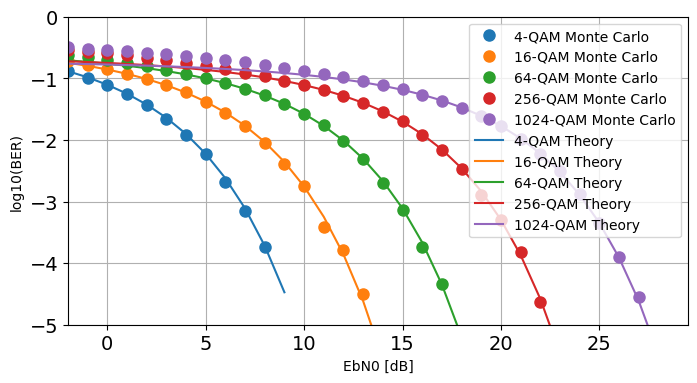

In [6]:
# Plot simulation results and theoretical curves        

plt.figure(figsize=(8, 4))

for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BER[:,ii]),'o', ms = 8, label = str(M)+'-QAM Monte Carlo')

plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(EbN0dB_, np.log10(BERth[:,ii]), label = str(M)+'-QAM Theory')

plt.ylim(-5, 0)
plt.xlim(min(EbN0dB_))
plt.xlabel('EbN0 [dB]', fontsize = 10)
plt.ylabel('log10(BER)', fontsize = 10)
plt.legend(fontsize = 10)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid()